<a href="https://colab.research.google.com/github/mrzhuzhe/Patrick/blob/main/V2_of_Resnet_hacked_detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Copy data

#### Version history
* V1 - First 60 eps
* V2 - 90 - 120 eps with lower start learning rate
* colab pro+ version 

In [ ]:
import os
!cat /proc/cpuinfo |grep "processor"|wc -l

2


In [ ]:
#!pip uninstall kaggle

In [ ]:
#!pip install kaggle --upgrade

In [ ]:
%env KAGGLE_USERNAME=drzhuzhe
%env KAGGLE_KEY=f7018e82f6ebede3ae2f454373576865

env: KAGGLE_USERNAME=drzhuzhe
env: KAGGLE_KEY=f7018e82f6ebede3ae2f454373576865


In [ ]:
#!kaggle kernels output drzhuzhe/createdatasetzip -p ./

In [ ]:
#!ls

In [ ]:
#!cp ./sartorius-cell-instance-segmentation.zip /content/drive/MyDrive/cell/sartorius-cell-instance-segmentation.zip
#!cp ./sartorius-kfold-coco.zip /content/drive/MyDrive/cell/sartorius-kfold-coco.zip

In [ ]:
!cp /content/drive/MyDrive/cell/sartorius-cell-instance-segmentation.zip ./sartorius-cell-instance-segmentation.zip
!cp /content/drive/MyDrive/cell/sartorius-kfold-coco.zip ./sartorius-kfold-coco.zip 

In [ ]:
!unzip -d ./ ./sartorius-cell-instance-segmentation.zip
!unzip -d ./ ./sartorius-kfold-coco.zip 

Streaming output truncated to the last 5000 lines.
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/shsy5y[diff]_D12-3_Vessel-714_2019-06-15_11h30m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astro[hippo]_G1-1_Vessel-361_2020-09-16_13h00m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astro[hippo]_G3-3_Vessel-361_2020-09-16_13h00m00s_Ph_1.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/cort[oka-high]_B6-1_Vessel-377_2020-11-04_19h30m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astros[cereb]_D7-1_Vessel-361_2020-09-14_09h00m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astros[cereb]_H9-2_Vessel-361_2020-09-14_09h00m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astros[cereb]_F12-

# Discuss
https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/292560

# Watch Out 

there are maybe some Bugs in backbone out_channel
and FPN RPN in channel configuration

# TODO 
1. split annotation to train and valid 【ok】
2. change learning rate scheduler 【ok】
3. Enable Amp 【ok】

# Refferences
1. https://detectron2.readthedocs.io/en/latest/modules/config.html
2. https://www.kaggle.com/slawekbiel/positive-score-with-detectron-2-3-training

# Install Dependences

In [ ]:
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch

In [ ]:
!pip install pyyaml==5.1


TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 8.5 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=ed4cfd71f341495aa516c5a299cc08997993f438bba7c694b2d6642a4c5d69d7
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 4.4 MB/s 
     |████████████████████████████████| 130 kB 12.2 MB/s 
     |████████████████████████████████| 74 kB 4.2 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 145 kB 56.0 MB/s 
     |████████████████████████████████| 843 kB 59.8 MB/s 
     |███████████████████████████████

In [ ]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

<Logger detectron2 (DEBUG)>

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [ ]:
__DATA_DIR = "./input"

In [ ]:
dataDir=Path(f'{__DATA_DIR}/sartorius-cell-instance-segmentation/')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, f'{__DATA_DIR}/sartorius-kfold-coco/fold_json/fold_1_train.json', dataDir)
register_coco_instances('sartorius_val',{}, f'{__DATA_DIR}/sartorius-kfold-coco/fold_json/fold_1_val.json', dataDir)

In [ ]:
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[12/09 03:52:21 d2.data.datasets.coco]: Loaded 484 images in COCO format from ./input/sartorius-kfold-coco/fold_json/fold_1_train.json


## Display a sample file to check the data is loaded correctly

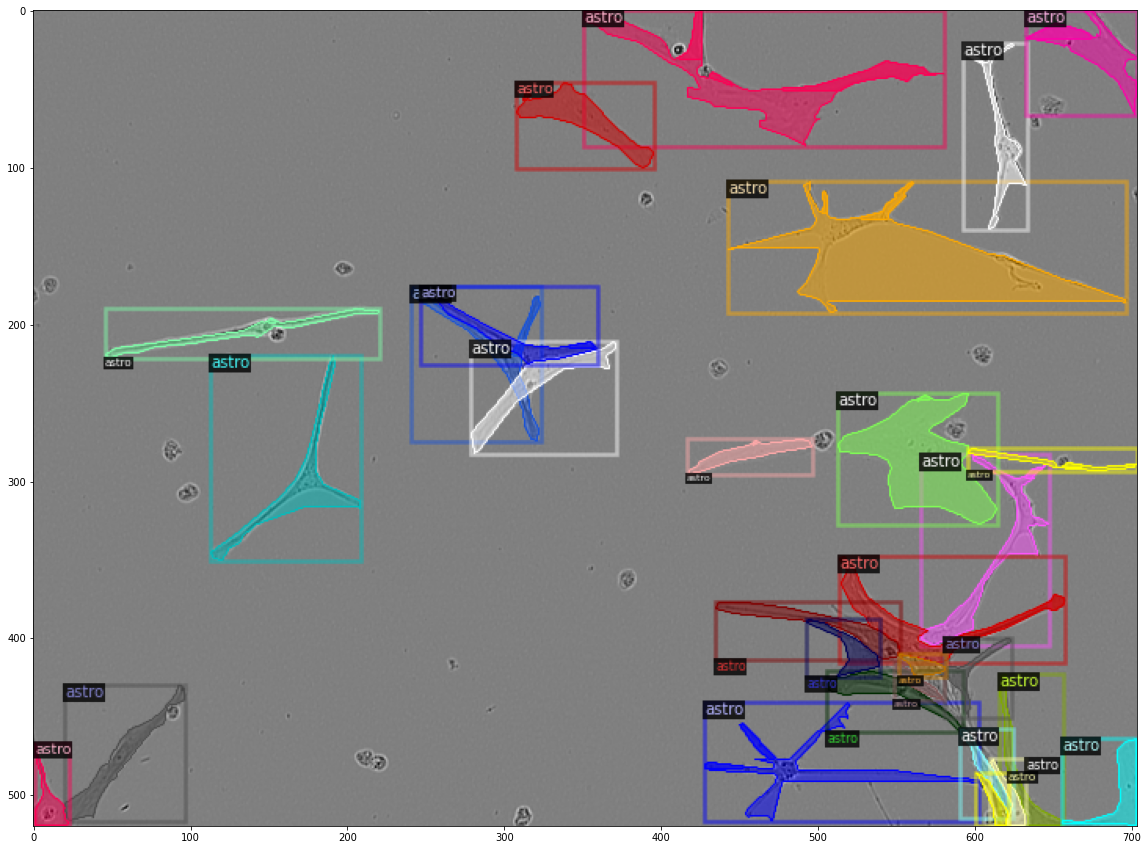

In [ ]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

# Define evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [ ]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}    

# Resnet backbone

In [ ]:
import math
import fvcore.nn.weight_init as weight_init
import torch
import torch.nn.functional as F
from torch import nn

from detectron2.modeling.backbone.build import BACKBONE_REGISTRY

In [ ]:
from detectron2.modeling.backbone import Backbone

from detectron2.layers import (
    Conv2d,
    ShapeSpec,
    get_norm,
)

In [ ]:
!pip install timm
import timm
from timm.models.efficientnet import *
from timm.models.resnet import *

     |████████████████████████████████| 376 kB 7.6 MB/s 


In [ ]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

# map 0.255 90 eps
#cfg.MODEL.WEIGHTS = "../input/retrain-of-efficientnetv2-hacked-detectron2/output/model_final.pth"

# Options: WarmupMultiStepLR, WarmupCosineLR.
# See detectron2/solver/build.py for definition.
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"

cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.IMS_PER_BATCH = 2

ITERATE_PER_EPOCH = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH 

print("ITERATE_PER_EPOCH", ITERATE_PER_EPOCH)

cfg.SOLVER.BASE_LR = 1e-3
cfg.SOLVER.MAX_ITER = ITERATE_PER_EPOCH * 40
#cfg.SOLVER.STEPS = (ITERATE_PER_EPOCH * 10, ITERATE_PER_EPOCH * 15)      

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5

cfg.TEST.EVAL_PERIOD =  ITERATE_PER_EPOCH   # Once per epoch

# Enable automatic mixed precision for training
cfg.SOLVER.AMP.ENABLED = True

cfg.INPUT.CROP.ENABLED = True
cfg.INPUT.CROP.SIZE = [0.9, 0.9]

#cfg.MODEL.ANCHOR_GENERATOR.SIZES: [[[16]], [32], [64], [128], [256], [512]]  # One size for each in feature map
#cfg.MODEL.FPN.IN_FEATURES = ["b0", "b1", "b2", "b4", "b5"]

#cfg.MODEL.RPN.IN_FEATURES: ["p1", "p2", "p3", "p4", "p5", "p6"]
#cfg.MODEL.ROI_HEADS.IN_FEATURES: ["p1", "p2", "p3", "p4", "p5"]
    
    
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

[12/09 03:52:26 d2.data.datasets.coco]: Loaded 484 images in COCO format from ./input/sartorius-kfold-coco/fold_json/fold_1_train.json
ITERATE_PER_EPOCH 242


In [ ]:
#e = resnet50(pretrained=True)
#print(e)

In [ ]:
class Resnet(Backbone):
    def __init__(self):
        super().__init__()

        e = resnet50(pretrained=True)
        
        all_features = ["stem", "res2", "res3", "res4", "res5"] 
        out_features = ["res2", "res3", "res4", "res5"] 
        _stride = [4, 1, 2, 2, 2]
        self._out_feature_strides = {"stem": 4, "res2": 4, "res3": 8, "res4": 16, "res5": 32}
        self._out_feature_channels = {"stem": 64, "res2": 256, "res3": 512, "res4": 1024, "res5": 2048}

        
        self.stem = nn.Sequential(
            e.conv1,
            e.bn1,
            e.act1,
            e.maxpool
        )
        
        self.res2 = e.layer1
        self.res3 = e.layer2
        self.res4 = e.layer3
        self.res5 = e.layer4

        # shall B7 conv_head be used ? 

        self.stages = [e.layer1, e.layer2, e.layer3, e.layer4]
        self.stage_names = all_features[1:]
        self._out_features = out_features


    def forward(self, x):
        """
        Args:
            x: Tensor of shape (N,C,H,W). H, W must be a multiple of ``self.size_divisibility``.

        Returns:
            dict[str->Tensor]: names and the corresponding features
        """
        assert x.dim() == 4, f"ResNet takes an input of shape (N, C, H, W). Got {x.shape} instead!"
        outputs = {}
        x = self.stem(x)
        if "stem" in self._out_features:
            outputs["stem"] = x
        for name, stage in zip(self.stage_names, self.stages):
            x = stage(x)
            if name in self._out_features:
                outputs[name] = x
        return outputs

    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }

In [ ]:
del BACKBONE_REGISTRY._obj_map["build_resnet_backbone"] 
@BACKBONE_REGISTRY.register()
def build_resnet_backbone(cfg, input_shape):    
    return Resnet()

## Sanity Test

In [ ]:
input_shape = ShapeSpec(channels=3, height=None, width=None, stride=None)
bottom_up = build_resnet_backbone(cfg, input_shape)
print("_out_feature_channels", bottom_up._out_feature_channels)
print("_out_feature_strides", bottom_up._out_feature_strides)
print("output_shape", bottom_up.output_shape())

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


_out_feature_channels {'stem': 64, 'res2': 256, 'res3': 512, 'res4': 1024, 'res5': 2048}
_out_feature_strides {'stem': 4, 'res2': 4, 'res3': 8, 'res4': 16, 'res5': 32}
output_shape {'res2': ShapeSpec(channels=256, height=None, width=None, stride=4), 'res3': ShapeSpec(channels=512, height=None, width=None, stride=8), 'res4': ShapeSpec(channels=1024, height=None, width=None, stride=16), 'res5': ShapeSpec(channels=2048, height=None, width=None, stride=32)}


# FPN backbone

In [ ]:
from detectron2.modeling.backbone.fpn import _assert_strides_are_log2_contiguous, LastLevelMaxPool

class FPN(Backbone):
    """
    This module implements :paper:`FPN`.
    It creates pyramid features built on top of some input feature maps.
    """

    _fuse_type: torch.jit.Final[str]

    def __init__(
        self, bottom_up, in_features, out_channels, norm="", top_block=None, fuse_type="sum"
    ):
        """
        Args:
            bottom_up (Backbone): module representing the bottom up subnetwork.
                Must be a subclass of :class:`Backbone`. The multi-scale feature
                maps generated by the bottom up network, and listed in `in_features`,
                are used to generate FPN levels.
            in_features (list[str]): names of the input feature maps coming
                from the backbone to which FPN is attached. For example, if the
                backbone produces ["res2", "res3", "res4"], any *contiguous* sublist
                of these may be used; order must be from high to low resolution.
            out_channels (int): number of channels in the output feature maps.
            norm (str): the normalization to use.
            top_block (nn.Module or None): if provided, an extra operation will
                be performed on the output of the last (smallest resolution)
                FPN output, and the result will extend the result list. The top_block
                further downsamples the feature map. It must have an attribute
                "num_levels", meaning the number of extra FPN levels added by
                this block, and "in_feature", which is a string representing
                its input feature (e.g., p5).
            fuse_type (str): types for fusing the top down features and the lateral
                ones. It can be "sum" (default), which sums up element-wise; or "avg",
                which takes the element-wise mean of the two.
        """
        super(FPN, self).__init__()
        assert isinstance(bottom_up, Backbone)
        assert in_features, in_features

        # Feature map strides and channels from the bottom up network (e.g. ResNet)
        input_shapes = bottom_up.output_shape()
        strides = [input_shapes[f].stride for f in in_features]
        in_channels_per_feature = [input_shapes[f].channels for f in in_features]
        
        _assert_strides_are_log2_contiguous(strides)
        lateral_convs = []
        output_convs = []

        use_bias = norm == ""
        for idx, in_channels in enumerate(in_channels_per_feature):
            lateral_norm = get_norm(norm, out_channels)
            output_norm = get_norm(norm, out_channels)

            lateral_conv = Conv2d(
                in_channels, out_channels, kernel_size=1, bias=use_bias, norm=lateral_norm
            )
            output_conv = Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=use_bias,
                norm=output_norm,
            )
            weight_init.c2_xavier_fill(lateral_conv)
            weight_init.c2_xavier_fill(output_conv)
            stage = int(math.log2(strides[idx]))
            self.add_module("fpn_lateral{}".format(stage), lateral_conv)
            self.add_module("fpn_output{}".format(stage), output_conv)

            lateral_convs.append(lateral_conv)
            output_convs.append(output_conv)
        # Place convs into top-down order (from low to high resolution)
        # to make the top-down computation in forward clearer.
        self.lateral_convs = lateral_convs[::-1]
        self.output_convs = output_convs[::-1]
        self.top_block = top_block
        self.in_features = tuple(in_features)
        self.bottom_up = bottom_up
        # Return feature names are "p<stage>", like ["p2", "p3", ..., "p6"]
        self._out_feature_strides = {"p{}".format(int(math.log2(s))): s for s in strides}
        # top block output feature maps.
        
        if self.top_block is not None:
            for s in range(stage, stage + self.top_block.num_levels):
                self._out_feature_strides["p{}".format(s + 1)] = 2 ** (s + 1)

        self._out_features = list(self._out_feature_strides.keys())
        self._out_feature_channels = {k: out_channels for k in self._out_features}
        self._size_divisibility = strides[-1]
        assert fuse_type in {"avg", "sum"}
        self._fuse_type = fuse_type

    @property
    def size_divisibility(self):
        return self._size_divisibility

    def forward(self, x):
        """
        Args:
            input (dict[str->Tensor]): mapping feature map name (e.g., "res5") to
                feature map tensor for each feature level in high to low resolution order.

        Returns:
            dict[str->Tensor]:
                mapping from feature map name to FPN feature map tensor
                in high to low resolution order. Returned feature names follow the FPN
                paper convention: "p<stage>", where stage has stride = 2 ** stage e.g.,
                ["p2", "p3", ..., "p6"].
        """
        bottom_up_features = self.bottom_up(x)
        results = []
        prev_features = self.lateral_convs[0](bottom_up_features[self.in_features[-1]])
        results.append(self.output_convs[0](prev_features))

        # Reverse feature maps into top-down order (from low to high resolution)
        for idx, (lateral_conv, output_conv) in enumerate(
            zip(self.lateral_convs, self.output_convs)
        ):
            # Slicing of ModuleList is not supported https://github.com/pytorch/pytorch/issues/47336
            # Therefore we loop over all modules but skip the first one
            if idx > 0:
                features = self.in_features[-idx - 1]
                features = bottom_up_features[features]
                top_down_features = F.interpolate(prev_features, scale_factor=2.0, mode="nearest")
                lateral_features = lateral_conv(features)
                prev_features = lateral_features + top_down_features
                if self._fuse_type == "avg":
                    prev_features /= 2
                results.insert(0, output_conv(prev_features))

        if self.top_block is not None:
            if self.top_block.in_feature in bottom_up_features:
                top_block_in_feature = bottom_up_features[self.top_block.in_feature]
            else:
                top_block_in_feature = results[self._out_features.index(self.top_block.in_feature)]
            results.extend(self.top_block(top_block_in_feature))
        assert len(self._out_features) == len(results)
        return {f: res for f, res in zip(self._out_features, results)}

    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }

del BACKBONE_REGISTRY._obj_map["build_resnet_fpn_backbone"] 
@BACKBONE_REGISTRY.register()
def build_resnet_fpn_backbone(cfg, input_shape: ShapeSpec):

    """
    Args:
        cfg: a detectron2 CfgNode

    Returns:
        backbone (Backbone): backbone module, must be a subclass of :class:`Backbone`.
    """
    bottom_up = build_resnet_backbone(cfg, input_shape)
    in_features = cfg.MODEL.FPN.IN_FEATURES
    out_channels = cfg.MODEL.FPN.OUT_CHANNELS
    backbone = FPN(
        bottom_up=bottom_up,
        in_features=in_features,
        out_channels=out_channels,
        norm=cfg.MODEL.FPN.NORM,
        top_block=LastLevelMaxPool(),
        fuse_type=cfg.MODEL.FPN.FUSE_TYPE,
    )
    return backbone

## Sanity Check

In [ ]:
bb = build_resnet_fpn_backbone(cfg, ShapeSpec(channels=3))
print(bb.output_shape())

{'p2': ShapeSpec(channels=256, height=None, width=None, stride=4), 'p3': ShapeSpec(channels=256, height=None, width=None, stride=8), 'p4': ShapeSpec(channels=256, height=None, width=None, stride=16), 'p5': ShapeSpec(channels=256, height=None, width=None, stride=32), 'p6': ShapeSpec(channels=256, height=None, width=None, stride=64)}


# Customize Trainer

In [ ]:
from prettytable import PrettyTable
import re
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    resnet_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        if re.search("backbone.bottom_up", name):
          resnet_params += param
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    print(f"Resnet Params: {resnet_params}")
    return total_params

In [ ]:
from detectron2.engine.defaults import create_ddp_model, default_writers
from detectron2.engine import hooks

from detectron2.data import (
    build_detection_test_loader,
    build_detection_train_loader,
)

from detectron2.engine.train_loop import AMPTrainer, SimpleTrainer, TrainerBase
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer


from detectron2.evaluation import (
    DatasetEvaluator,
    inference_on_dataset,
    print_csv_format,
    verify_results,
)

import weakref
import logging
from detectron2.utils import comm
from collections import OrderedDict

class CustomizeTrainer(TrainerBase):
    """
    A trainer with default training logic. It does the following:

    1. Create a :class:`SimpleTrainer` using model, optimizer, dataloader
       defined by the given config. Create a LR scheduler defined by the config.
    2. Load the last checkpoint or `cfg.MODEL.WEIGHTS`, if exists, when
       `resume_or_load` is called.
    3. Register a few common hooks defined by the config.

    It is created to simplify the **standard model training workflow** and reduce code boilerplate
    for users who only need the standard training workflow, with standard features.
    It means this class makes *many assumptions* about your training logic that
    may easily become invalid in a new research. In fact, any assumptions beyond those made in the
    :class:`SimpleTrainer` are too much for research.

    The code of this class has been annotated about restrictive assumptions it makes.
    When they do not work for you, you're encouraged to:

    1. Overwrite methods of this class, OR:
    2. Use :class:`SimpleTrainer`, which only does minimal SGD training and
       nothing else. You can then add your own hooks if needed. OR:
    3. Write your own training loop similar to `tools/plain_train_net.py`.

    See the :doc:`/tutorials/training` tutorials for more details.

    Note that the behavior of this class, like other functions/classes in
    this file, is not stable, since it is meant to represent the "common default behavior".
    It is only guaranteed to work well with the standard models and training workflow in detectron2.
    To obtain more stable behavior, write your own training logic with other public APIs.

    Examples:
    ::
        trainer = DefaultTrainer(cfg)
        trainer.resume_or_load()  # load last checkpoint or MODEL.WEIGHTS
        trainer.train()

    Attributes:
        scheduler:
        checkpointer (DetectionCheckpointer):
        cfg (CfgNode):
    """

    def __init__(self, cfg):
        """
        Args:
            cfg (CfgNode):
        """
        super().__init__()
        logger = logging.getLogger("detectron2")
        if not logger.isEnabledFor(logging.INFO):  # setup_logger is not called for d2
            setup_logger()
        cfg = self.auto_scale_workers(cfg, comm.get_world_size())

        # Assume these objects must be constructed in this order.
        model = self.build_model(cfg)
        optimizer = self.build_optimizer(cfg, model)
        data_loader = self.build_train_loader(cfg)

        model = create_ddp_model(model, broadcast_buffers=False)

        #pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        #print("parameters", sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values()))
        
        #print("pytorch_total_params", pytorch_total_params)
        count_parameters(model)
            
        self._trainer = (AMPTrainer if cfg.SOLVER.AMP.ENABLED else SimpleTrainer)(
            model, data_loader, optimizer
        )

        self.scheduler = self.build_lr_scheduler(cfg, optimizer)
        self.checkpointer = DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR,
            trainer=weakref.proxy(self),
        )
        self.start_iter = 0
        self.max_iter = cfg.SOLVER.MAX_ITER
        self.cfg = cfg

        self.register_hooks(self.build_hooks())

    def resume_or_load(self, resume=True):
        """
        If `resume==True` and `cfg.OUTPUT_DIR` contains the last checkpoint (defined by
        a `last_checkpoint` file), resume from the file. Resuming means loading all
        available states (eg. optimizer and scheduler) and update iteration counter
        from the checkpoint. ``cfg.MODEL.WEIGHTS`` will not be used.

        Otherwise, this is considered as an independent training. The method will load model
        weights from the file `cfg.MODEL.WEIGHTS` (but will not load other states) and start
        from iteration 0.

        Args:
            resume (bool): whether to do resume or not
        """
        self.checkpointer.resume_or_load(self.cfg.MODEL.WEIGHTS, resume=resume)
        if resume and self.checkpointer.has_checkpoint():
            # The checkpoint stores the training iteration that just finished, thus we start
            # at the next iteration
            self.start_iter = self.iter + 1

    def build_hooks(self):
        """
        Build a list of default hooks, including timing, evaluation,
        checkpointing, lr scheduling, precise BN, writing events.

        Returns:
            list[HookBase]:
        """
        cfg = self.cfg.clone()
        cfg.defrost()
        cfg.DATALOADER.NUM_WORKERS = 0  # save some memory and time for PreciseBN

        ret = [
            hooks.IterationTimer(),
            hooks.LRScheduler(),
            hooks.PreciseBN(
                # Run at the same freq as (but before) evaluation.
                cfg.TEST.EVAL_PERIOD,
                self.model,
                # Build a new data loader to not affect training
                self.build_train_loader(cfg),
                cfg.TEST.PRECISE_BN.NUM_ITER,
            )
            if cfg.TEST.PRECISE_BN.ENABLED and get_bn_modules(self.model)
            else None,
        ]

        # Do PreciseBN before checkpointer, because it updates the model and need to
        # be saved by checkpointer.
        # This is not always the best: if checkpointing has a different frequency,
        # some checkpoints may have more precise statistics than others.
        if comm.is_main_process():
            ret.append(hooks.PeriodicCheckpointer(self.checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD))

        def test_and_save_results():
            self._last_eval_results = self.test(self.cfg, self.model)
            return self._last_eval_results

        # Do evaluation after checkpointer, because then if it fails,
        # we can use the saved checkpoint to debug.
        ret.append(hooks.EvalHook(cfg.TEST.EVAL_PERIOD, test_and_save_results))

        if comm.is_main_process():
            # Here the default print/log frequency of each writer is used.
            # run writers in the end, so that evaluation metrics are written
            ret.append(hooks.PeriodicWriter(self.build_writers(), period=20))
        return ret

    def build_writers(self):
        """
        Build a list of writers to be used using :func:`default_writers()`.
        If you'd like a different list of writers, you can overwrite it in
        your trainer.

        Returns:
            list[EventWriter]: a list of :class:`EventWriter` objects.
        """
        return default_writers(self.cfg.OUTPUT_DIR, self.max_iter)

    def train(self):
        """
        Run training.

        Returns:
            OrderedDict of results, if evaluation is enabled. Otherwise None.
        """
        super().train(self.start_iter, self.max_iter)
        if len(self.cfg.TEST.EXPECTED_RESULTS) and comm.is_main_process():
            assert hasattr(
                self, "_last_eval_results"
            ), "No evaluation results obtained during training!"
            verify_results(self.cfg, self._last_eval_results)
            return self._last_eval_results

    def run_step(self):
        self._trainer.iter = self.iter
        self._trainer.run_step()

    def state_dict(self):
        ret = super().state_dict()
        ret["_trainer"] = self._trainer.state_dict()
        return ret

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self._trainer.load_state_dict(state_dict["_trainer"])

    @classmethod
    def build_model(cls, cfg):
        """
        Returns:
            torch.nn.Module:

        It now calls :func:`detectron2.modeling.build_model`.
        Overwrite it if you'd like a different model.
        """
        model = build_model(cfg)
        print("Model", model)
        logger = logging.getLogger(__name__)
        logger.info("Model:\n{}".format(model))
        return model

    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Returns:
            torch.optim.Optimizer:

        It now calls :func:`detectron2.solver.build_optimizer`.
        Overwrite it if you'd like a different optimizer.
        """
        return build_optimizer(cfg, model)

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)

    @classmethod
    def build_train_loader(cls, cfg):
        """
        Returns:
            iterable

        It now calls :func:`detectron2.data.build_detection_train_loader`.
        Overwrite it if you'd like a different data loader.
        """
        return build_detection_train_loader(cfg)

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        """
        Returns:
            iterable

        It now calls :func:`detectron2.data.build_detection_test_loader`.
        Overwrite it if you'd like a different data loader.
        """
        return build_detection_test_loader(cfg, dataset_name)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

    @classmethod
    def test(cls, cfg, model, evaluators=None):
        """
        Evaluate the given model. The given model is expected to already contain
        weights to evaluate.

        Args:
            cfg (CfgNode):
            model (nn.Module):
            evaluators (list[DatasetEvaluator] or None): if None, will call
                :meth:`build_evaluator`. Otherwise, must have the same length as
                ``cfg.DATASETS.TEST``.

        Returns:
            dict: a dict of result metrics
        """
        logger = logging.getLogger(__name__)
        if isinstance(evaluators, DatasetEvaluator):
            evaluators = [evaluators]
        if evaluators is not None:
            assert len(cfg.DATASETS.TEST) == len(evaluators), "{} != {}".format(
                len(cfg.DATASETS.TEST), len(evaluators)
            )

        results = OrderedDict()
        for idx, dataset_name in enumerate(cfg.DATASETS.TEST):
            data_loader = cls.build_test_loader(cfg, dataset_name)
            # When evaluators are passed in as arguments,
            # implicitly assume that evaluators can be created before data_loader.
            if evaluators is not None:
                evaluator = evaluators[idx]
            else:
                try:
                    evaluator = cls.build_evaluator(cfg, dataset_name)
                except NotImplementedError:
                    logger.warn(
                        "No evaluator found. Use `DefaultTrainer.test(evaluators=)`, "
                        "or implement its `build_evaluator` method."
                    )
                    results[dataset_name] = {}
                    continue
            results_i = inference_on_dataset(model, data_loader, evaluator)
            results[dataset_name] = results_i
            if comm.is_main_process():
                assert isinstance(
                    results_i, dict
                ), "Evaluator must return a dict on the main process. Got {} instead.".format(
                    results_i
                )
                logger.info("Evaluation results for {} in csv format:".format(dataset_name))
                print_csv_format(results_i)

        if len(results) == 1:
            results = list(results.values())[0]
        return results

    @staticmethod
    def auto_scale_workers(cfg, num_workers: int):
        """
        When the config is defined for certain number of workers (according to
        ``cfg.SOLVER.REFERENCE_WORLD_SIZE``) that's different from the number of
        workers currently in use, returns a new cfg where the total batch size
        is scaled so that the per-GPU batch size stays the same as the
        original ``IMS_PER_BATCH // REFERENCE_WORLD_SIZE``.

        Other config options are also scaled accordingly:
        * training steps and warmup steps are scaled inverse proportionally.
        * learning rate are scaled proportionally, following :paper:`ImageNet in 1h`.

        For example, with the original config like the following:

        .. code-block:: yaml

            IMS_PER_BATCH: 16
            BASE_LR: 0.1
            REFERENCE_WORLD_SIZE: 8
            MAX_ITER: 5000
            STEPS: (4000,)
            CHECKPOINT_PERIOD: 1000

        When this config is used on 16 GPUs instead of the reference number 8,
        calling this method will return a new config with:

        .. code-block:: yaml

            IMS_PER_BATCH: 32
            BASE_LR: 0.2
            REFERENCE_WORLD_SIZE: 16
            MAX_ITER: 2500
            STEPS: (2000,)
            CHECKPOINT_PERIOD: 500

        Note that both the original config and this new config can be trained on 16 GPUs.
        It's up to user whether to enable this feature (by setting ``REFERENCE_WORLD_SIZE``).

        Returns:
            CfgNode: a new config. Same as original if ``cfg.SOLVER.REFERENCE_WORLD_SIZE==0``.
        """
        old_world_size = cfg.SOLVER.REFERENCE_WORLD_SIZE
        if old_world_size == 0 or old_world_size == num_workers:
            return cfg
        cfg = cfg.clone()
        frozen = cfg.is_frozen()
        cfg.defrost()

        assert (
            cfg.SOLVER.IMS_PER_BATCH % old_world_size == 0
        ), "Invalid REFERENCE_WORLD_SIZE in config!"
        scale = num_workers / old_world_size
        bs = cfg.SOLVER.IMS_PER_BATCH = int(round(cfg.SOLVER.IMS_PER_BATCH * scale))
        lr = cfg.SOLVER.BASE_LR = cfg.SOLVER.BASE_LR * scale
        max_iter = cfg.SOLVER.MAX_ITER = int(round(cfg.SOLVER.MAX_ITER / scale))
        warmup_iter = cfg.SOLVER.WARMUP_ITERS = int(round(cfg.SOLVER.WARMUP_ITERS / scale))
        cfg.SOLVER.STEPS = tuple(int(round(s / scale)) for s in cfg.SOLVER.STEPS)
        cfg.TEST.EVAL_PERIOD = int(round(cfg.TEST.EVAL_PERIOD / scale))
        cfg.SOLVER.CHECKPOINT_PERIOD = int(round(cfg.SOLVER.CHECKPOINT_PERIOD / scale))
        cfg.SOLVER.REFERENCE_WORLD_SIZE = num_workers  # maintain invariant
        logger = logging.getLogger(__name__)
        logger.info(
            f"Auto-scaling the config to batch_size={bs}, learning_rate={lr}, "
            f"max_iter={max_iter}, warmup={warmup_iter}."
        )

        if frozen:
            cfg.freeze()
        return cfg

# Access basic attributes from the underlying trainer
for _attr in ["model", "data_loader", "optimizer"]:
    setattr(
        CustomizeTrainer,
        _attr,
        property(
            # getter
            lambda self, x=_attr: getattr(self._trainer, x),
            # setter
            lambda self, value, x=_attr: setattr(self._trainer, x, value),
        ),
    )

# Training

In [ ]:
trainer = CustomizeTrainer(cfg) 
#trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Model GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): Resnet(
      (stem): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPo

model_final_f10217.pkl: 178MB [00:01, 89.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[12/09 03:52:49 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual fl

[12/09 03:53:20 d2.utils.events]:  eta: 1:35:58  iter: 19  total_loss: 4.29  loss_cls: 1.285  loss_box_reg: 0.3417  loss_mask: 0.6926  loss_rpn_cls: 1.599  loss_rpn_loc: 0.4257  time: 1.3442  data_time: 1.0249  lr: 0.00019076  max_mem: 4257M
[12/09 03:53:49 d2.utils.events]:  eta: 1:42:25  iter: 39  total_loss: 2.89  loss_cls: 0.7823  loss_box_reg: 0.4426  loss_mask: 0.667  loss_rpn_cls: 0.5428  loss_rpn_loc: 0.4323  time: 1.4167  data_time: 0.9564  lr: 0.00039051  max_mem: 5218M
[12/09 03:54:23 d2.utils.events]:  eta: 1:42:13  iter: 59  total_loss: 2.584  loss_cls: 0.6796  loss_box_reg: 0.3532  loss_mask: 0.6376  loss_rpn_cls: 0.5215  loss_rpn_loc: 0.3922  time: 1.5133  data_time: 1.1712  lr: 0.00059025  max_mem: 5218M
[12/09 03:54:51 d2.utils.events]:  eta: 1:44:29  iter: 79  total_loss: 2.674  loss_cls: 0.6766  loss_box_reg: 0.5136  loss_mask: 0.6273  loss_rpn_cls: 0.3834  loss_rpn_loc: 0.4123  time: 1.4858  data_time: 0.8661  lr: 0.00079  max_mem: 5218M
[12/09 03:55:26 d2.utils.eve

### Lets look at some of the validation files to check if things look reasonable
We show predictions on the left and ground truth on the right

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])